# Produce geometrical XY map

<i>
This notebook takes a clean kDST and a correction file,
performs the lifetime correction and measures the energy
at different points of the XY plane. The resulting map
is stored in the same correction file.
</i>

In [22]:
import os

run_numbers          = 6202, 6206
nrun                 = len(run_numbers)
input_dst_filenames  = [os.path.expandvars(f"$IC_DATA/ldst/dst_{run_number}.h5") for run_number in run_numbers]
geo_filename         = os.path.expandvars(f"$IC_DATA/maps/geo_{nrun}.h5")
output_dst_filename = os.path.expandvars(f"$IC_DATA/gdst/dst_{nrun}.h5")

print(f"run numbers  = {run_numbers}")
print(f"nrun.        = {nrun}")
print(f"input dsts   = {input_dst_filenames}")
print(f"geo_filename = {geo_filename}")
print(f"output dst   = {output_dst_filename}")

run numbers  = (6202, 6206)
nrun.        = 2
input dsts   = ['/Users/jjgomezcadenas/Projects/ICDATA/ldst/dst_6202.h5', '/Users/jjgomezcadenas/Projects/ICDATA/ldst/dst_6206.h5']
geo_filename = /Users/jjgomezcadenas/Projects/ICDATA/maps/geo_2.h5
output dst   = /Users/jjgomezcadenas/Projects/ICDATA/gdst/dst_2.h5


In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Notebook configuration

### Imports

In [56]:
import time
import collections
import warnings
import pandas as pd
import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer

from icaro.core.fit_functions import gauss_seed
from icaro.core.fit_functions import relative_errors
from icaro.core.fit_functions import conditional_labels


In [60]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf
import core.kr_plt_functions as krp

In [26]:
from dataclasses import dataclass

In [51]:
from core.kr_types import KrEvent, DstEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import XyzRanges, XyzNBins, XyzBins
from core.kr_types import kr_event
from core.kr_types import kr_times_ranges_and_bins
from core.kr_types import kr_ranges_and_bins
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits
from   invisible_cities.evm  .ic_containers  import Measurement

In [52]:
from typing      import List, Tuple

In [45]:
# Plotting style
default_cmap = "viridis"
figure_size  = 16, 12
font_size    = 15

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)



In [29]:
from tables import NoSuchNodeError
from tables import HDF5ExtError
import warnings

def load_dst(filename, group, node):
    try:
        with tb.open_file(filename) as h5in:
            try:
                table = getattr(getattr(h5in.root, group), node).read()
                return pd.DataFrame.from_records(table)
            except NoSuchNodeError:
                print(f' warning:  {filename} not of kdst type')
    except HDF5ExtError:
        print(f' warning:  {filename} corrupted')
        
def load_dsts(dst_list, group, node):
    dsts = [load_dst(filename, group, node) for filename in dst_list]
    return pd.concat(dsts)



In [30]:
def fiducial_volumes(dst):
    dst_full   = dst[dst.R < R_full]
    dst_fid    = dst[dst.R < R_fid]
    dst_core   = dst[dst.R < R_core]
    dst_hcore  = dst[dst.R < R_hcore]

    kdst= DstEvent(full  = kr_event(dst_full),
               fid   = kr_event(dst_fid),
               core  = kr_event(dst_core),
               hcore = kr_event(dst_hcore))
    return kdst

### Ranges and binning

In [31]:
eRanges, eNBins, eBins = kr_ranges_and_bins(Zrange  = ( 100,  550),
                                                     XYrange = (-200,  200),
                                                     Erange  = ( 2e3, 14e3),
                                                     S1range = (   0,   30),
                                                     Qrange  = ( 100, 1000),
                                                     Znbins        =   10,
                                                     XYnbins       =   100,
                                                     Enbins        =   50,
                                                     S1nbins       =   10,
                                                     Qnbins        =   25)

### Read data

In [32]:
dst = load_dsts(input_dst_filenames, "DST", "Events")

In [33]:
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 1953682 
Total number of events: 1608809


In [34]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [35]:
R_full   = 200
R_fid    = 150
R_core   = 100
R_hcore  =  50
print(f" Rfull : {R_full}: Rfiducial : {R_fid}: Rcore = {R_core} Rhcore = {R_hcore} ")

 Rfull : 200: Rfiducial : 150: Rcore = 100 Rhcore = 50 


In [36]:
kdst = fiducial_volumes(dst)

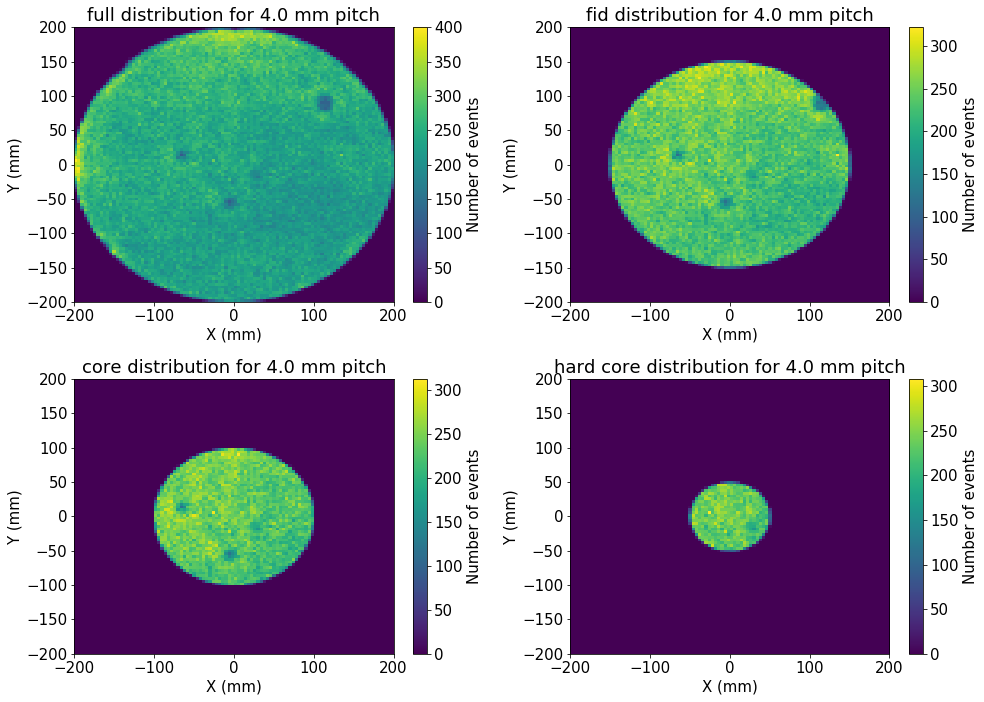

In [37]:
nEvt = krp.plot_xy_density(kdst, eBins)

### Event distribution

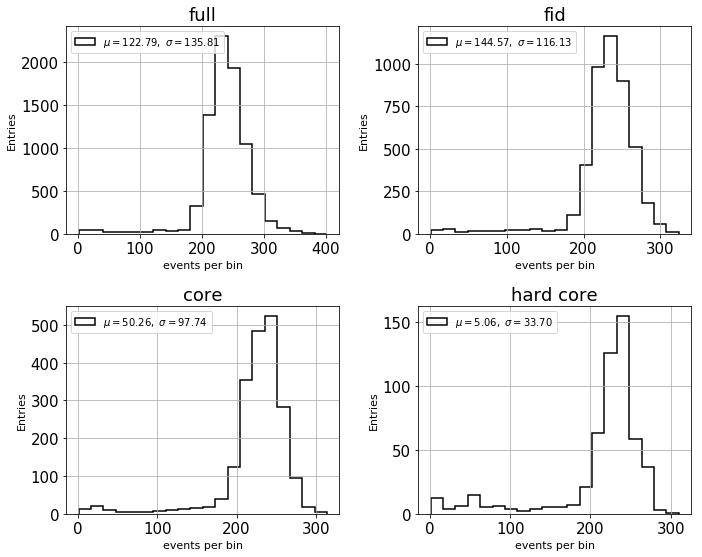

In [38]:
stats = krh.h1n(n=4, nx=2, ny=2, 
                names = ("nevt_full", "fnevt_id", "nevt_core", "nevt_hard core"),
                h1ds = (nEvt.full.flatten(), nEvt.fid.flatten(), nEvt.core.flatten(), nEvt.hcore.flatten()),
                bins = (20, 20, 20, 20),
                ranges = ((1, int(np.max(nEvt.full)) + 2), (1, int(np.max(nEvt.fid)) + 2), 
               (1, int(np.max(nEvt.core)) + 2), (1, int(np.max(nEvt.hcore)) + 2)),
               xlabels = ("events per bin", "events per bin", "events per bin", "events per bin"),
               ylabels = ("Entries", "Entries", "Entries", "Entries"),
               titles = ("full", "fid", "core", "hard core"),
               legends = ("upper left", "upper left", "upper left", "upper left"),
               figsize =(10,8))

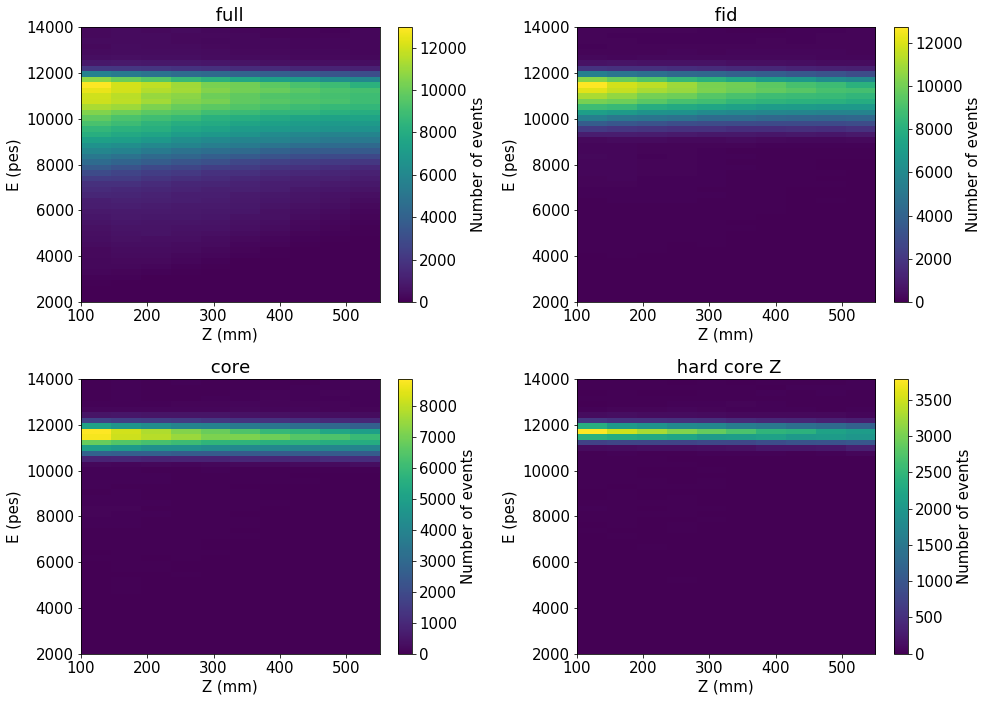

In [39]:
krp.plot_s2_vs_z(kdst, eBins, figsize=(14,10))

### Compute geometry map

In [41]:
 *_, Eave_, Eaveu_ = fitf.profileXY(kdst.full.X, kdst.full.Y, kdst.full.E, 
                                    eNBins.XY, eNBins.XY, eRanges.XY, 
                                    eRanges.XY)
Eaveu_            = relative_errors(Eave_, Eaveu_, percentual=True)
Eok               = Eave_ > 1e3

In [42]:
Eave  = Eave_
Eaveu = Eaveu_
    
E_mean  = np.mean(Eave_ [Eok])
E_std   = np.std (Eave_ [Eok])
Eu_mean = np.mean(Eaveu_[Eok])
Eu_std  = np.std (Eaveu_[Eok])
    
E_min   =      E_mean - 2.5 *  E_std
E_max   =      E_mean + 2.5 *  E_std

Eu_min  = max(Eu_mean - 2.5 * Eu_std, 1e-3)
Eu_max  =     Eu_mean + 2.5 * Eu_std

print(f' E_mean = {E_mean} : E_std = {E_std}')
print(f' Eu_mean = {Eu_mean} : Eu_std = {Eu_std}')
print(f' E_min = {E_min} : E_max = {E_max}')
print(f' Eu_min = {Eu_min} : Eu_max = {Eu_max}')

 E_mean = 10002.021132703294 : E_std = 1370.627842177356
 Eu_mean = 0.7260586520477079 : Eu_std = 0.7337010866314941
 E_min = 6575.451527259904 : E_max = 13428.590738146684
 Eu_min = 0.001 : Eu_max = 2.560311368626443


In [9]:
Eave  = {}
Eaveu = {}

E_mean  = {}
Eu_mean = {}
E_std   = {}
Eu_std  = {}

E_min  = {}
E_max  = {}
Eu_min = {}
Eu_max = {}

Qave  = {}
Qaveu = {}

Q_mean  = {}
Qu_mean = {}
Q_std   = {}
Qu_std  = {}

Q_min  = {}
Q_max  = {}
Qu_min = {}
Qu_max = {}

for n in XYnbins:
    *_, Eave_, Eaveu_ = fitf.profileXY(X, Y, E, n, n, XYrange, XYrange)
    *_, Qave_, Qaveu_ = fitf.profileXY(X, Y, Q, n, n, XYrange, XYrange)

    Eaveu_            = relative_errors(Eave_, Eaveu_, percentual=True)
    Qaveu_            = relative_errors(Qave_, Qaveu_, percentual=True)

    Eok               = Eave_ > 1e3
    Qok               = Qave_ > 1e1

    Eave   [n] = Eave_
    Eaveu  [n] = Eaveu_
    
    E_mean [n] = np.mean(Eave_ [Eok])
    E_std  [n] = np.std (Eave_ [Eok])
    Eu_mean[n] = np.mean(Eaveu_[Eok])
    Eu_std [n] = np.std (Eaveu_[Eok])
    
    E_min  [n] =      E_mean[n] - 3.0 *  E_std[n]
    E_max  [n] =      E_mean[n] + 2.0 *  E_std[n]

    Eu_min [n] = max(Eu_mean[n] - 1.5 * Eu_std[n], 1e-3)
    Eu_max [n] =     Eu_mean[n] + 2.0 * Eu_std[n]

    
    Qave   [n] = Qave_
    Qaveu  [n] = Qaveu_
    
    Q_mean [n] = np.mean(Qave_ [Qok])
    Q_std  [n] = np.std (Qave_ [Qok])
    Qu_mean[n] = np.mean(Qaveu_[Qok])
    Qu_std [n] = np.std (Qaveu_[Qok])
    
    Q_min  [n] =      Q_mean[n] - 3.0 *  Q_std[n]
    Q_max  [n] =      Q_mean[n] + 2.0 *  Q_std[n]

    Qu_min [n] = max(Qu_mean[n] - 1.5 * Qu_std[n], 1e-3)
    Qu_max [n] =     Qu_mean[n] + 2.0 * Qu_std[n]

### Fit example

 E (z=0) = 298015.1984092048 +-7967.206201670617 
 LT      = 11779.166140166466 +-6.097666766281506 
 chi2    = 1.527316165636087 


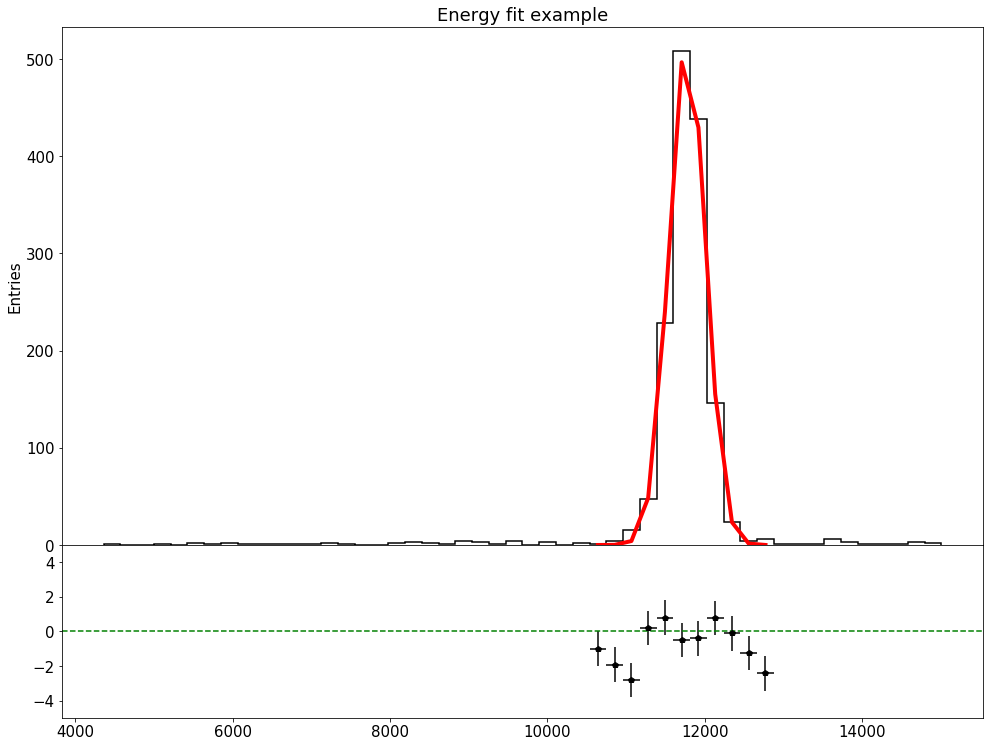

In [62]:
kf = krf.energy_in_XYRange(kdst.full, 
                           xr = (-5,  5),
                           yr = (-5,  5),
                           ernb = eNBins)
krf.print_fit(kf)

 E (z=0) = 104066.01007440795 +-5217.056108335759 
 LT      = 9702.038309058444 +-10.283632390828329 
 chi2    = 1.162888193571949 


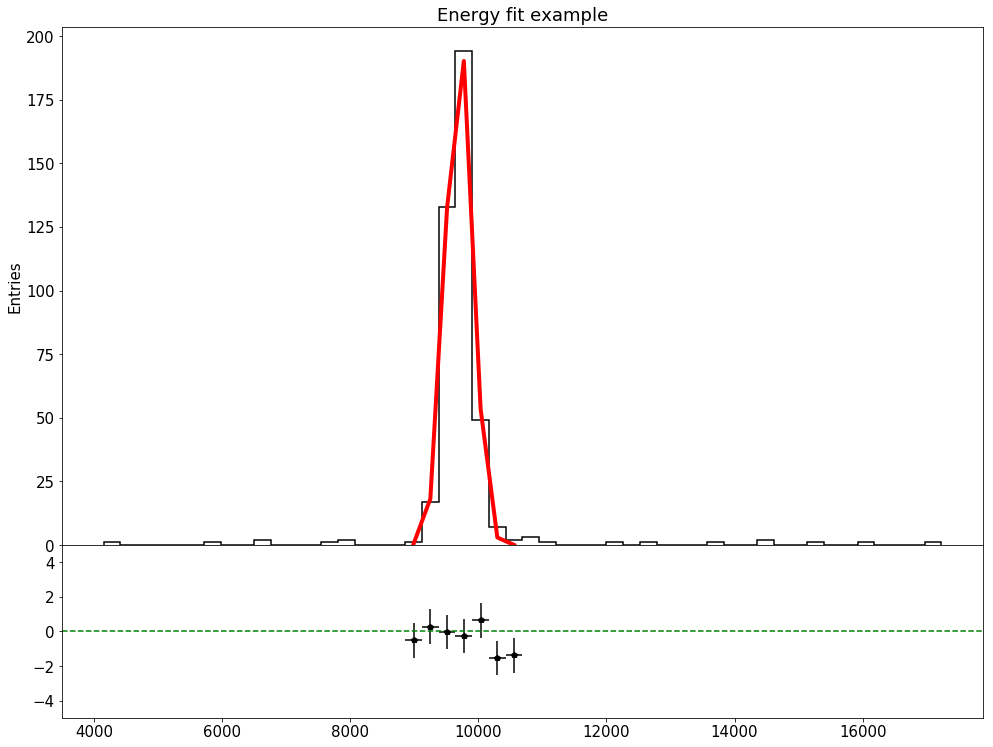

In [64]:
kf = krf.energy_in_XYRange(kdst.full, 
                           xr = (100,  105),
                           yr = (100,  105),
                           ernb = eNBins)
krf.print_fit(kf)

### Energy map display

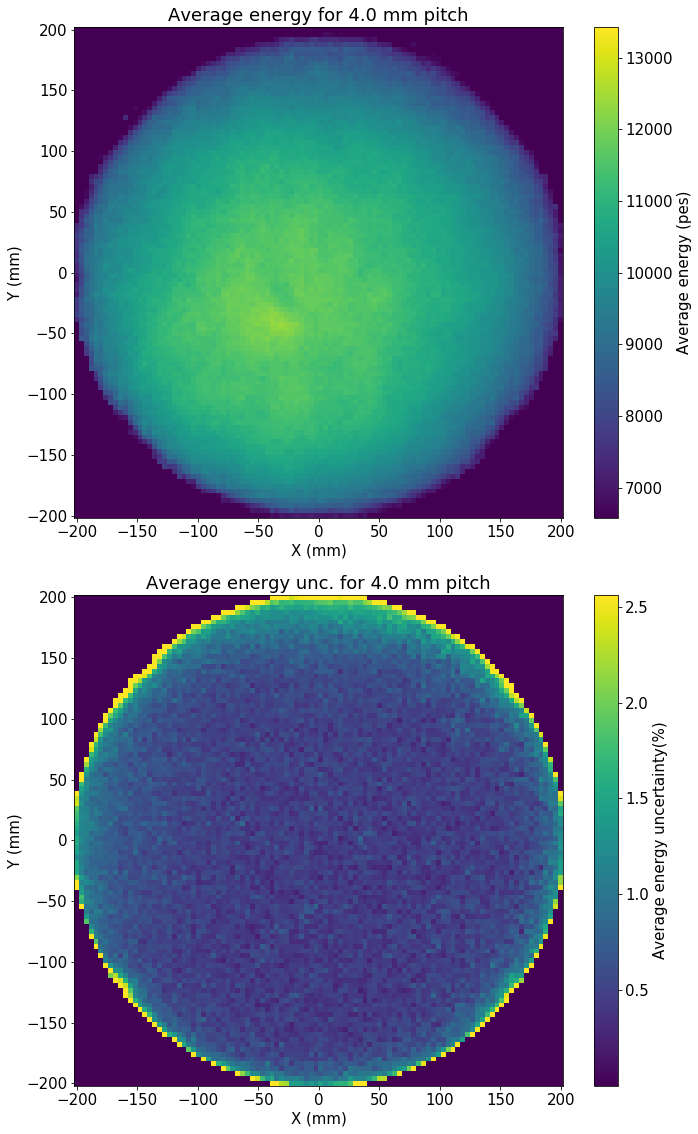

In [71]:
fig = plt.figure(figsize=(10,16))
pitch = eBins.pXY
fig.add_subplot(2, 1, 1)
*_, cb = display_matrix(eBins.cXY, eBins.cXY, Eave,
                        vmin = E_min,
                        vmax = E_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Average energy (pes)")
labels("X (mm)", "Y (mm)", f"Average energy for {pitch:.1f} mm pitch")
fig.add_subplot(2, 1, 2)
*_, cb = display_matrix(eBins.cXY, eBins.cXY, Eaveu,
                            vmin = Eu_min,
                            vmax = Eu_max,
                            cmap = default_cmap,
                            new_figure = False)
cb.set_label("Average energy uncertainty(%)")
labels("X (mm)", "Y (mm)", f"Average energy unc. for {pitch:.1f} mm pitch")

plt.tight_layout()





### Produce HDF5 output

In [75]:
with tb.open_file(geo_filename, "w") as output_file:
   
    pitch      = eBins.pXY
    group      =  "XYcorrections"
    table_name = f"GeometryE_{pitch:.1f}mm"
        
    write = kdstio.xy_correction_writer(output_file,
                                            group      = group,
                                            table_name = table_name)
    write(eBins.cXY, eBins.cXY, Eave, Eaveu * Eave / 100, nEvt.full)

    table = getattr(getattr(output_file.root, group), table_name)
    table.attrs.xy_bins  = eBins.XY
    table.attrs.xy_pitch = pitch



### Write DST (merged and fiducial)

In [76]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [77]:
del dst['index']

In [79]:
dst.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)



In [80]:
with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"